# Variational Auto-Encoder (VAE)

### Zhenwen Dai (2018-8-21)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference
%matplotlib inline
from pylab import *

## Load a toy dataset

In [2]:
import GPy
data = GPy.util.datasets.oil_100()
Y = data['X']
label = data['Y'].argmax(1)

In [3]:
N, D = Y.shape

## Model Defintion

In [4]:
Q = 2

In [5]:
H = 50
encoder = nn.HybridSequential(prefix='encoder_')
with encoder.name_scope():
    encoder.add(nn.Dense(H, activation="tanh"))
    encoder.add(nn.Dense(H, activation="tanh"))
    encoder.add(nn.Dense(Q, flatten=True))
encoder.initialize(mx.init.Xavier(magnitude=3))
_=encoder(mx.nd.array(np.random.rand(5,D)))

In [6]:
H = 50
decoder = nn.HybridSequential(prefix='decoder_')
with decoder.name_scope():
    decoder.add(nn.Dense(H, activation="tanh"))
    decoder.add(nn.Dense(H, activation="tanh"))
    decoder.add(nn.Dense(D, flatten=True))
decoder.initialize(mx.init.Xavier(magnitude=3))
_=decoder(mx.nd.array(np.random.rand(5,Q)))

In [9]:
from mxfusion.components.variables.var_trans import PositiveTransformation

In [11]:
m = mf.models.Model()
m.N = mf.components.Variable()
m.decoder = mf.components.functions.MXFusionGluonFunction(decoder, num_outputs=1,broadcastable=False)
m.x = mf.components.distributions.Normal.define_variable(mean=mx.nd.array([0]), variance=mx.nd.array([1]), shape=(m.N, Q))
m.f = m.decoder(m.x)
m.noise_var = mf.components.Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([0.01]))
m.y = mf.components.distributions.Normal.define_variable(mean=m.f, variance=m.noise_var, shape=(m.N, D))
print(m)

x ~ Normal(mean=Variable(0e4af), variance=Variable(04719))
f = GluonFunctionEvaluation(decoder_dense0_weight=Variable(12a27), decoder_dense0_bias=Variable(aa4b5), decoder_dense1_weight=Variable(7d30c), decoder_dense1_bias=Variable(52f1e), decoder_dense2_weight=Variable(872ca), decoder_dense2_bias=Variable(3b875), decoder_input_0=x)
y ~ Normal(mean=f, variance=noise_var)


In [13]:
q = mf.models.Posterior(m)
q.x_var = mf.components.Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([1e-6]))
q.encoder = mf.components.functions.MXFusionGluonFunction(encoder, num_outputs=1, broadcastable=False)
q.x_mean = q.encoder(q.y)
q.x.set_prior(mf.components.distributions.Normal(mean=q.x_mean, variance=q.x_var))
print(q)

x_mean = GluonFunctionEvaluation(encoder_dense0_weight=Variable(fb22e), encoder_dense0_bias=Variable(066a2), encoder_dense1_weight=Variable(5a487), encoder_dense1_bias=Variable(0b0b0), encoder_dense2_weight=Variable(ae8ed), encoder_dense2_bias=Variable(7b560), encoder_input_0=y)
x ~ Normal(mean=x_mean, variance=x_var)


## Variational Inference

In [14]:
from mxfusion.inference import BatchInferenceLoop, StochasticVariationalInference, GradBasedInference

In [15]:
observed = [m.y]
alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [16]:
infr.run(max_iter=2000, learning_rate=1e-2, y=mx.nd.array(Y), verbose=True)

Iteration 1 logL: -1460.925048828125
Iteration 2 logL: -1562.58935546875
Iteration 3 logL: -1281.037109375
Iteration 4 logL: -1202.09814453125
Iteration 5 logL: -1215.446533203125
Iteration 6 logL: -1242.7581787109375
Iteration 7 logL: -1206.203125
Iteration 8 logL: -1193.624755859375
Iteration 9 logL: -1133.6195068359375
Iteration 10 logL: -1112.78466796875
Iteration 11 logL: -1098.210205078125
Iteration 12 logL: -1090.024169921875
Iteration 13 logL: -1077.6949462890625
Iteration 14 logL: -1074.197021484375
Iteration 15 logL: -1060.966796875
Iteration 16 logL: -1047.22314453125
Iteration 17 logL: -1042.4344482421875
Iteration 18 logL: -1035.609619140625
Iteration 19 logL: -1028.633544921875
Iteration 20 logL: -1029.137939453125
Iteration 21 logL: -1024.3011474609375
Iteration 22 logL: -1023.6302490234375
Iteration 23 logL: -1019.930908203125
Iteration 24 logL: -1010.139892578125
Iteration 25 logL: -1006.3385009765625
Iteration 26 logL: -1000.4537353515625
Iteration 27 logL: -994.98229

Iteration 228 logL: -296.8038330078125
Iteration 229 logL: -289.93829345703125
Iteration 230 logL: -273.60772705078125
Iteration 231 logL: -273.5848083496094
Iteration 232 logL: -274.60516357421875
Iteration 233 logL: -279.79559326171875
Iteration 234 logL: -265.37139892578125
Iteration 235 logL: -268.1728515625
Iteration 236 logL: -286.05657958984375
Iteration 237 logL: -258.6796875
Iteration 238 logL: -263.93536376953125
Iteration 239 logL: -246.65869140625
Iteration 240 logL: -252.12294006347656
Iteration 241 logL: -238.3090362548828
Iteration 242 logL: -242.03961181640625
Iteration 243 logL: -278.21551513671875
Iteration 244 logL: -252.17791748046875
Iteration 245 logL: -262.09869384765625
Iteration 246 logL: -233.151611328125
Iteration 247 logL: -229.36944580078125
Iteration 248 logL: -235.25
Iteration 249 logL: -217.96437072753906
Iteration 250 logL: -253.81582641601562
Iteration 251 logL: -189.49090576171875
Iteration 252 logL: -224.6653594970703
Iteration 253 logL: -199.2982940

Iteration 446 logL: 229.65565490722656
Iteration 447 logL: 250.59280395507812
Iteration 448 logL: 256.8097839355469
Iteration 449 logL: 256.7193603515625
Iteration 450 logL: 261.1778564453125
Iteration 451 logL: 244.57467651367188
Iteration 452 logL: 227.16921997070312
Iteration 453 logL: 264.9154357910156
Iteration 454 logL: 214.16091918945312
Iteration 455 logL: 226.58319091796875
Iteration 456 logL: 254.50091552734375
Iteration 457 logL: 209.54544067382812
Iteration 458 logL: 250.94309997558594
Iteration 459 logL: 267.63702392578125
Iteration 460 logL: 270.45306396484375
Iteration 461 logL: 240.05918884277344
Iteration 462 logL: 272.01611328125
Iteration 463 logL: 275.1655578613281
Iteration 464 logL: 253.60137939453125
Iteration 465 logL: 273.5705261230469
Iteration 466 logL: 264.79888916015625
Iteration 467 logL: 274.9527587890625
Iteration 468 logL: 284.63226318359375
Iteration 469 logL: 266.7030334472656
Iteration 470 logL: 245.265869140625
Iteration 471 logL: 249.99008178710938

Iteration 667 logL: 572.25732421875
Iteration 668 logL: 472.2418212890625
Iteration 669 logL: 530.1259155273438
Iteration 670 logL: 553.6770629882812
Iteration 671 logL: 515.36083984375
Iteration 672 logL: 546.8098754882812
Iteration 673 logL: 558.6419677734375
Iteration 674 logL: 536.229248046875
Iteration 675 logL: 552.6064453125
Iteration 676 logL: 563.158935546875
Iteration 677 logL: 492.94036865234375
Iteration 678 logL: 495.3648986816406
Iteration 679 logL: 554.4259033203125
Iteration 680 logL: 551.0859985351562
Iteration 681 logL: 564.0114135742188
Iteration 682 logL: 600.528564453125
Iteration 683 logL: 573.399658203125
Iteration 684 logL: 579.81640625
Iteration 685 logL: 611.6653442382812
Iteration 686 logL: 602.6742553710938
Iteration 687 logL: 606.689208984375
Iteration 688 logL: 618.3515625
Iteration 689 logL: 600.56103515625
Iteration 690 logL: 596.6321411132812
Iteration 691 logL: 602.9988403320312
Iteration 692 logL: 621.69580078125
Iteration 693 logL: 622.3204345703125


Iteration 896 logL: 855.877685546875
Iteration 897 logL: 809.4588012695312
Iteration 898 logL: 815.0318603515625
Iteration 899 logL: 867.521484375
Iteration 900 logL: 851.146484375
Iteration 901 logL: 819.41845703125
Iteration 902 logL: 807.7691650390625
Iteration 903 logL: 866.3160400390625
Iteration 904 logL: 885.31884765625
Iteration 905 logL: 857.8840942382812
Iteration 906 logL: 875.3470458984375
Iteration 907 logL: 875.8247680664062
Iteration 908 logL: 855.70361328125
Iteration 909 logL: 863.3753662109375
Iteration 910 logL: 903.119873046875
Iteration 911 logL: 815.6651611328125
Iteration 912 logL: 852.3782348632812
Iteration 913 logL: 896.301513671875
Iteration 914 logL: 883.7418823242188
Iteration 915 logL: 884.7936401367188
Iteration 916 logL: 885.785888671875
Iteration 917 logL: 893.6766357421875
Iteration 918 logL: 884.5655517578125
Iteration 919 logL: 889.199462890625
Iteration 920 logL: 889.278564453125
Iteration 921 logL: 882.70654296875
Iteration 922 logL: 888.0932617187

Iteration 1123 logL: 935.5863647460938
Iteration 1124 logL: 1004.2960815429688
Iteration 1125 logL: 998.3340454101562
Iteration 1126 logL: 1012.7325439453125
Iteration 1127 logL: 982.7613525390625
Iteration 1128 logL: 989.0130615234375
Iteration 1129 logL: 967.0189208984375
Iteration 1130 logL: 1010.2852172851562
Iteration 1131 logL: 996.5936279296875
Iteration 1132 logL: 1003.2515869140625
Iteration 1133 logL: 1021.8541259765625
Iteration 1134 logL: 1001.3343505859375
Iteration 1135 logL: 974.9999389648438
Iteration 1136 logL: 1002.3839721679688
Iteration 1137 logL: 953.425537109375
Iteration 1138 logL: 959.832763671875
Iteration 1139 logL: 1046.0775146484375
Iteration 1140 logL: 992.5029907226562
Iteration 1141 logL: 971.2471923828125
Iteration 1142 logL: 1038.533447265625
Iteration 1143 logL: 1005.0819091796875
Iteration 1144 logL: 965.291748046875
Iteration 1145 logL: 1028.6328125
Iteration 1146 logL: 971.9251708984375
Iteration 1147 logL: 958.4278564453125
Iteration 1148 logL: 101

Iteration 1343 logL: 1088.1441650390625
Iteration 1344 logL: 1015.7085571289062
Iteration 1345 logL: 968.54638671875
Iteration 1346 logL: 1015.0870361328125
Iteration 1347 logL: 1105.8619384765625
Iteration 1348 logL: 1055.509033203125
Iteration 1349 logL: 1014.1629638671875
Iteration 1350 logL: 1033.0728759765625
Iteration 1351 logL: 1073.4019775390625
Iteration 1352 logL: 1080.45361328125
Iteration 1353 logL: 1045.367431640625
Iteration 1354 logL: 1084.0126953125
Iteration 1355 logL: 1106.8497314453125
Iteration 1356 logL: 1079.021728515625
Iteration 1357 logL: 1036.01123046875
Iteration 1358 logL: 1030.1357421875
Iteration 1359 logL: 1036.358154296875
Iteration 1360 logL: 1086.20556640625
Iteration 1361 logL: 1091.220703125
Iteration 1362 logL: 1099.4813232421875
Iteration 1363 logL: 1108.89892578125
Iteration 1364 logL: 1044.771484375
Iteration 1365 logL: 1019.5564575195312
Iteration 1366 logL: 1036.892822265625
Iteration 1367 logL: 1119.0032958984375
Iteration 1368 logL: 1115.5268

Iteration 1556 logL: 1143.199462890625
Iteration 1557 logL: 1129.498779296875
Iteration 1558 logL: 1142.629638671875
Iteration 1559 logL: 1171.317138671875
Iteration 1560 logL: 1133.0269775390625
Iteration 1561 logL: 1151.3790283203125
Iteration 1562 logL: 1166.7060546875
Iteration 1563 logL: 1170.1600341796875
Iteration 1564 logL: 1130.2381591796875
Iteration 1565 logL: 1159.63623046875
Iteration 1566 logL: 1163.8935546875
Iteration 1567 logL: 1161.8206787109375
Iteration 1568 logL: 1129.810302734375
Iteration 1569 logL: 1150.504150390625
Iteration 1570 logL: 1147.615478515625
Iteration 1571 logL: 1131.1220703125
Iteration 1572 logL: 1135.4644775390625
Iteration 1573 logL: 1137.3548583984375
Iteration 1574 logL: 1131.8143310546875
Iteration 1575 logL: 1115.718017578125
Iteration 1576 logL: 1150.552001953125
Iteration 1577 logL: 1148.207763671875
Iteration 1578 logL: 1133.901123046875
Iteration 1579 logL: 1137.3487548828125
Iteration 1580 logL: 1181.746826171875
Iteration 1581 logL: 11

Iteration 1768 logL: 1187.64501953125
Iteration 1769 logL: 1084.9339599609375
Iteration 1770 logL: 1098.33935546875
Iteration 1771 logL: 1176.05615234375
Iteration 1772 logL: 1064.9852294921875
Iteration 1773 logL: 1022.5030517578125
Iteration 1774 logL: 1140.70458984375
Iteration 1775 logL: 1164.1103515625
Iteration 1776 logL: 1135.731201171875
Iteration 1777 logL: 1128.5531005859375
Iteration 1778 logL: 1196.467529296875
Iteration 1779 logL: 1104.288818359375
Iteration 1780 logL: 1097.5933837890625
Iteration 1781 logL: 1182.5947265625
Iteration 1782 logL: 1127.6785888671875
Iteration 1783 logL: 1029.875732421875
Iteration 1784 logL: 1132.1024169921875
Iteration 1785 logL: 1163.4666748046875
Iteration 1786 logL: 1150.5213623046875
Iteration 1787 logL: 1195.85888671875
Iteration 1788 logL: 1157.4736328125
Iteration 1789 logL: 1163.945068359375
Iteration 1790 logL: 1171.854248046875
Iteration 1791 logL: 1181.27880859375
Iteration 1792 logL: 1177.8392333984375
Iteration 1793 logL: 1204.9

Iteration 1979 logL: 1157.0384521484375
Iteration 1980 logL: 1148.7764892578125
Iteration 1981 logL: 1126.78369140625
Iteration 1982 logL: 1098.42041015625
Iteration 1983 logL: 1102.987548828125
Iteration 1984 logL: 1150.337646484375
Iteration 1985 logL: 1221.3736572265625
Iteration 1986 logL: 1196.589111328125
Iteration 1987 logL: 1132.331787109375
Iteration 1988 logL: 1090.274169921875
Iteration 1989 logL: 1141.44921875
Iteration 1990 logL: 1223.2042236328125
Iteration 1991 logL: 1237.2412109375
Iteration 1992 logL: 1190.1959228515625
Iteration 1993 logL: 1173.37548828125
Iteration 1994 logL: 1207.7738037109375
Iteration 1995 logL: 1243.5345458984375
Iteration 1996 logL: 1226.81005859375
Iteration 1997 logL: 1231.50341796875
Iteration 1998 logL: 1240.9560546875
Iteration 1999 logL: 1225.5052490234375
Iteration 2000 logL: 1224.2252197265625


## Plot the training data in the latent space

In [17]:
q_x_mean = q.encoder.block(mx.nd.array(Y)).asnumpy()

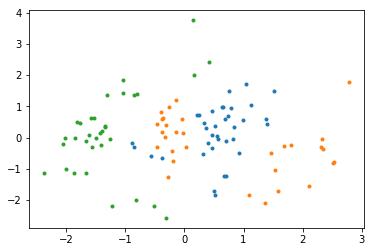

In [18]:
for i in range(3):
    plot(q_x_mean[label==i,0], q_x_mean[label==i,1], '.')